# Data cleaning and preparation
Before we jump into the EDA (explortory data analysis), we need to get our data cleaned and ready.

# Where is the data from?
This project uses data that has been scraped from Board Game Geek (https://boardgamegeek.com) and made available on Kaggle.

**Source** [Board Game Reviews - Jan 2025] https://www.kaggle.com/datasets/bwandowando/boardgamegeek-board-games-reviews-jan-2025

**Author Credit** [bwandowando] https://www.kaggle.com/bwandowando

# About the raw data
The dataset consists of 4 csv files with some of the fields shown below:
- boardgames.csv (Titles, Descriptions, Release Year, Ratings)
- boardgames_reviews.csv (Pseudo Users, Comments, Post Date, Rating)
- users.csv (Pseudo Users, Location, Badges)
- user_game_status.csv (Pseudo Users, Ownership, Wishlisted)

Before loading the raw data into Jupyter Notebooks, I completed some intial data cleaining in SQL.

---


## File 1 - boardgames.csv
The raw boardgames csv file initially looks like this:

![Raw_boardgames_file](../images/Raw_boardgames_file.png)

# The changes I made to this file are:
- Renamed column headers (more for personal preference, but it also helps me to remember what fields I have)
- Removed "link" and "thumbnail" as I don't currently need them

I then ran the below SQL code:
![boardgames_file_SQL_code](../images/boardgames_file_SQL_code.png)

Which can be copied below:

SELECT
	a."Rank",
	a."Game ID",
	a."Title",
	a."Description",
	a."Release Year",
	a."Geek Rating",
	a."Avg Rating",
	a."Voters"
FROM
	( 	SELECT 
			ROW_NUMBER () OVER ( PARTITION BY a."Game ID" ORDER BY a."Game ID" ) AS "Rn",
			a."Rank",
			a."Game ID",
			a."Title",
			a."Description",
			a."Year" AS "Release Year",
			a."Geek Rating",
			a."Avg Rating",
			a."Voters"	
		FROM 	
			dbo."BPP - Board Games" a
		WHERE 	
			a."Geek Rating" IS NOT NULL 
		AND 	
			a."Year" IS NOT NULL 		
		AND		
			a."Game ID" IS NOT NULL 				
		AND 	
			a."Rank" IS NOT NULL		
		AND
		 	a."Year" < 2024
	) a
WHERE a."Rn" = 1 
ORDER BY a."Rank"

# What does this do?

- The Raw file consists of 161,404 "board games". I use quotes here as I would argue not every entry is actually a board game.
- Firstly, any game without a "Geek Rating" is removed. More details about the Geek rating are below. This reduce our list of games from 161,404 to 38,059.
- Some games do not have a release year. Perhaps no one knows when these games were released. Anyway, they were removed from the dataset reducing the total by a further 276 to 37,783 games. Games without a release year included things like Go Fish and Poker Dice etc.
- Some games did not feature a "Game ID" or a "Rank". These were often game expansions and second editions. These were all excluded removing a further 10,943 leaving 26,840. That's still a lot of games! I have decided to remove these from the initial analysis as initially, I just want to determine the features of the original game to see if it is a classic. For a game to have a second edition or expansion, it must have garnered some level of success, which we could analyze later on. I also dont want the rating of the original game to be influences by and expansions or second editions, yet.
- Any duplicate "Game ID" were also removed, just in case, but there were no duplicates, but seemed silly to remove the code which was doing no harm.
- Lastly, I removed any games released in 2024. This is because I want to work with full years worth of data. This ensured every game on the list can contain at least one years worth of data. This removed another 1,045 games.

This leaves our starting pot of games at...
# 25,795



# Understanding a Geek Rating
The dataset includes two key rating metrics for each board game.
- **Average Rating** - The average of all user submitted scores (out of 10).
- **Geek Rating** - This is a **Bayesian-adjusted score** used by BoardGameGeek (BGG) to provide a fairer ranking for games.

A Bayesian average is used to adjust the games rating based on:
- The number of votes received (v).
- The average rating (r).
- The overall average rating across all games on BGG (c) (the average rating across all games is often around 5.5).
- A constant (m) is also introduced which determines the minimum number of votes required before a games rating is even considered.

# The formula

$$
\text{Geek Rating} = \frac{v}{v + m} \cdot R + \frac{m}{v + m} \cdot C
$$

# Example 1 : A new game with just a few votes
Let's see a brand new game, with only a few votes. 
- **R** = 9.0 - an excellent raw average score.
- **V** = 25 - only 25 people have rated it so far. However, this would now threaten to be the best game ever from the opinion of only 25 people.
- **C** = 5.5 - The average review score of all games on BGG.
- **M** = 1000 - The constant, used to determine the minimum number of votes required. Kind of works like a weighting (1000 used for illustrative purposes, the actual constant used by BGG might be different).

Lets plug all of this into the formula:
$$
\text{Geek Rating} = \frac{25}{25 + 1000} \cdot 9.0 + \frac{1000}{25 + 1000} \cdot 5.5
$$

<br>

$$
= 0.024 \cdot 9.0 + 0.976 \cdot 5.5 = 0.22 + 5.37 = \mathbf{5.59}
$$

This reduces the rating from **9.0** to **5.59**! Our new game will need a much higher volume of positive reviews to climb to the top spot.

# Example 2 : CATAN - A very popular game released in 1995
- **R** = 7.09
- **V** = 132623 
- **C** = 5.5 
- **M** = 1000

Again, lets plug all of this into the formula:
$$
\text{Geek Rating} = \frac{132623}{132623 + 1000} \cdot 7.09 + \frac{1000}{132623 + 1000} \cdot 5.5
$$

<br>

$$
= 0.993 \cdot 7.09 + 0.976 \cdot 5.5 = 7.04 + 0.04 = \mathbf{7.08}
$$

Due to the high volume of ratings for CATAN, the Geek Rating does not differ much from the non-adjusted average, going from **7.09** to **7.08**. 

# Why use this calculation?
The geek rating is designed to prevent games with just a few (potentially biased) scores from ranking too high or too low.
In this project I will be using the Geek Rating to assess a game's **overall perceived quality**, since it accounts for both rating score and the number of votes.



## Importing the cleaned boardgames dataset
After performing the initial data cleaining in SQL, I exported the clean result to a CSV file and will now load it into the notebook using Python and pandas. 

To recap, in the cleaned dataset:
- Any duplicate game ID's have been removed
- The game must have a Geek Rating
- The game must have a Release Year
- The game must have an ID and a Rank
- The game must have been released before 2024

This dataset will be used for further cleaning and feature engineering in this notebook. Below is an example of the first 10 rows of the SQL cleaned and formatted data so that we can see what we are working with.

In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Show the top 10 rows
df.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters
0,1,224517,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,8.407,8.58,50109
1,2,161936,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,8.370,8.52,54954
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624
3,4,174430,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,8.335,8.57,64071
4,5,233078,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,8.232,8.58,25359
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081
7,8,115746,War of the Ring: Second Edition,The Fellowship and the Free Peoples clash with...,2011,8.192,8.55,22685
8,9,187645,Star Wars: Rebellion,Strike from your hidden base as the Rebels—or ...,2016,8.169,8.42,33850
9,10,162886,Spirit Island,Island Spirits join forces using elemental pow...,2017,8.144,8.34,55560


# Release year distribution and outliers
The below code adds a column called "Adjusted Release Year". It look at the release year and if it was before 2001, it adjust the release year to 2001. If the release year is 2001 ot later, it retains the original release year.

In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df['Adjusted Release Year'] = df['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Sort by oldest release year
df_sorted = df.sort_values(by='Release Year', ascending=True)

# Show the top 10 rows
df_sorted.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year
2991,3080,2932,Hnefatafl,Defenders protect the king from invaders!,400,5.983,6.67,1749,2001
25782,27884,2136,Pachisi,Be the first to get all your pieces around the...,400,4.710,4.52,5800,2001
15840,17148,13654,Yut Nori,A race to be the first to get your horses arou...,500,5.523,5.87,174,2001
16857,18322,18011,Chaturanga,An ancient Indian chess predecessor.,550,5.518,6.00,117,2001
6179,6413,28302,Oware,Sow and reap to harvest more than opponent does.,550,5.674,6.52,471,2001
13790,14799,41247,Mia,A dice game of deception and probabilities.,600,5.533,5.92,217,2001
4025,4156,2448,Kalah,Move your seeds strategically to capture your ...,700,5.836,5.99,7555,2001
7744,8076,11929,Go-Moku,"Alternately placing stones on a grid, you try ...",700,5.616,5.98,786,2001
1979,2026,2393,Xiangqi,Use cannons and more to defeat the enemy Gener...,762,6.216,7.10,2187,2001
7547,7874,315,Bagh Chal,"Translated as ""tigers moving"", this abstract s...",1000,5.621,6.22,441,2001


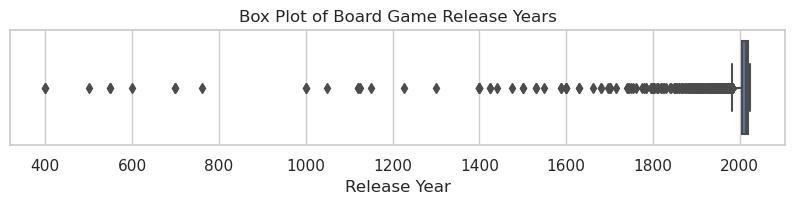

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Set the style
sns.set(style="whitegrid")

# Create a box plot of release years
plt.figure(figsize=(10, 1.5)) 
sns.boxplot(x=df['Release Year'])

# Add title and labels
plt.title('Box Plot of Board Game Release Years')
plt.xlabel('Release Year')

# Show plot
plt.show()

As you can see from the above box plot, we have some extreme outliers when it comes to board game release year. Even if we take into account these 1000+ year old games, the average release year across all games is still 2007. I decided to set a minimum release year of 2001 and called this the "Adjusted Release Year". If we then produce the same box plot on this adjusted column we get this:

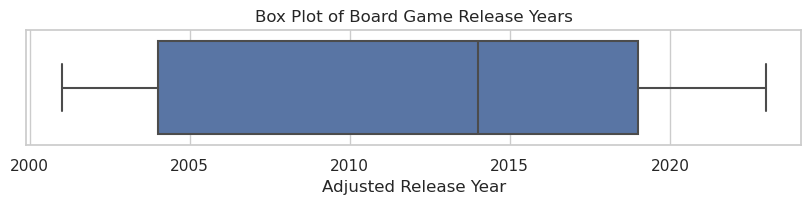

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df['Adjusted Release Year'] = df['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Set the style
sns.set(style="whitegrid")

# Create a box plot of release years
plt.figure(figsize=(10, 1.5)) 
sns.boxplot(x=df['Adjusted Release Year'])

# Add title and labels
plt.title('Box Plot of Board Game Release Years')
plt.xlabel('Adjusted Release Year')

# Show plot
plt.show()

This transformation forms an important step before we build our statistical analysis model. At the very least it improves visual clarity.
- It ensures modern (and the vast majority of) games are not compressed into a narrow range due to the skew from extreme values.
- It prevents misleading analysis from things like average values being adjusted significantly by the outlying data.
- It improves the readability of charts and summaries.
- It ensure any trend analysis is based on realistic and relevant data.

By adjusting the release year, we preserve the integrity of recent games whilst reducing the influence of abnormal records. 

# Adding the years since adjusted release 
Once I had my adjusted release year I wanted a way to demonstrate games with a sustained popularity, not just those with initial hype that quickly tailed off. To be able to determine if a game can reach a classic status, it needs to stand the test of time. 

To do this, I am going to look at the number of votes a game has received this, and divide it by the number of years since its adjusted release year. I am going to exclude 2025 from the calculation as this will not contain a full years worth of votes.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df['Adjusted Release Year'] = df['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Calculate the number of years since the games adjusted release year
df['Years Since Release'] = 2024 - df['Adjusted Release Year']

# Avoid division by 0
df['Years Since Release'] = df['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df['Votes per Adjusted Release Year'] = df['Voters'] / df['Years Since Release']
df['Votes per Adjusted Release Year'] = df ['Votes per Adjusted Release Year'].round(0).astype(int)

# Show the top 10 rows
df.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year
0,1,224517,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,8.407,8.58,50109,2018,6,8352
1,2,161936,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,8.370,8.52,54954,2015,9,6106
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624,2021,3,16541
3,4,174430,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,8.335,8.57,64071,2017,7,9153
4,5,233078,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,8.232,8.58,25359,2017,7,3623
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373,2020,4,12593
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081,2016,8,13010
7,8,115746,War of the Ring: Second Edition,The Fellowship and the Free Peoples clash with...,2011,8.192,8.55,22685,2011,13,1745
8,9,187645,Star Wars: Rebellion,Strike from your hidden base as the Rebels—or ...,2016,8.169,8.42,33850,2016,8,4231
9,10,162886,Spirit Island,Island Spirits join forces using elemental pow...,2017,8.144,8.34,55560,2017,7,7937


# About the votes per year
Now that we have a column calculating the votes per year for every game, lets have a look and see if we have any outliers:

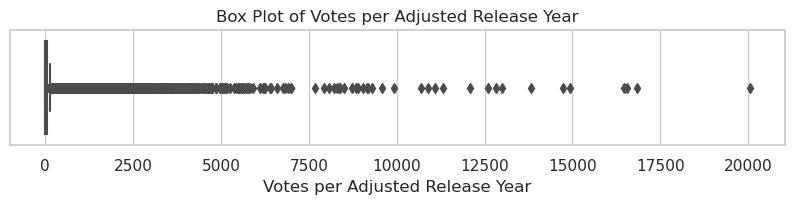

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df['Adjusted Release Year'] = df['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Calculate the number of years since the games adjusted release year
df['Years Since Release'] = 2024 - df['Adjusted Release Year']

# Avoid division by 0
df['Years Since Release'] = df['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df['Votes per Adjusted Release Year'] = df['Voters'] / df['Years Since Release']
df['Votes per Adjusted Release Year'] = df ['Votes per Adjusted Release Year'].round(0).astype(int)

# Create box plot on Votes per Adjusted Release Year
plt.figure(figsize=(10, 1.5))
sns.boxplot(x=df['Votes per Adjusted Release Year'])
plt.title('Box Plot of Votes per Adjusted Release Year' )
plt.xlabel('Votes per Adjusted Release Year')
plt.show()

Yep! Definitely some outliers in there! I know you are wondering, which game received over 20k votes per year since it's release...

It's **Wingspan**, released in 2019, it has received an 100,230 votes in the 5 years since it's release.

![Wingspan](../images/Wingspan.png)


# So what can we do about this distribution?
Something fair that does not change a games overall perceived popularity. Whatever we do, Wingspan still needs to be at the top (and rightly so).

# Apply Standard Deviation
This will give us a **relative popularity score** based on how for a games "Votes per Adjusted Year" is from the average, measured in standard deviations. 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df['Adjusted Release Year'] = df['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Calculate the number of years since the games adjusted release year
df['Years Since Release'] = 2024 - df['Adjusted Release Year']

# Avoid division by 0
df['Years Since Release'] = df['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df['Votes per Adjusted Release Year'] = df['Voters'] / df['Years Since Release']
df['Votes per Adjusted Release Year'] = df ['Votes per Adjusted Release Year'].round(0).astype(int)

# Calculate the standard deviation on Votes per Adjusted Release Year and apply it as a weighting column
mean_votes = df['Votes per Adjusted Release Year'].mean()
std_dev_votes = df['Votes per Adjusted Release Year'].std(ddof=0)
df['SDs from Mean'] = (df['Votes per Adjusted Release Year'] - mean_votes) / std_dev_votes
df['SD Weight'] = 1 / ((df['SDs from Mean'].abs() + 1))
df['Weighted Result'] = df['Votes per Adjusted Release Year'] * df['SD Weight']
df['Weighted Result'] = df['Weighted Result'].round(2)

# Normalised results on a scale of -1 to 1 and name it Popularity
min_sd = df['Weighted Result'].min()
max_sd = df['Weighted Result'].max()
df['Popularity'] = 2 * ((df['Weighted Result'] - min_sd) / (max_sd - min_sd)) - 1
df['Popularity'] = df['Popularity'].round(2)

# Sort by most votes per adjusted release year
df_sorted = df.sort_values(by='Votes per Adjusted Release Year', ascending=False)

# Show the top 10 rows
df_sorted.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year,SDs from Mean,SD Weight,Weighted Result,Popularity
31,32,266192,Wingspan,Attract a beautiful and diverse collection of ...,2019,7.879,8.03,100230,2019,5,20046,33.254458,0.029193,585.21,1.00
191,197,350184,Earth,Strategically grow your ecosystem card engine ...,2023,7.356,7.65,16840,2023,1,16840,27.897978,0.034604,582.74,0.99
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624,2021,3,16541,27.398418,0.035213,582.46,0.99
39,40,373106,Sky Team,Pilot and co-pilot work together to land planes.,2023,7.815,8.18,16465,2023,1,16465,27.271440,0.035371,582.39,0.99
48,49,295947,Cascadia,Create the most harmonious ecosystem as you pu...,2021,7.758,7.93,44767,2021,3,14922,24.693446,0.038920,580.77,0.98
40,41,366013,Heat: Pedal to the Metal,Manage your race car's speed to keep from over...,2022,7.799,8.03,29490,2022,2,14745,24.397720,0.039374,580.56,0.98
81,83,230802,Azul,Artfully embellish the walls of your palace by...,2017,7.626,7.74,96691,2017,7,13813,22.840565,0.041945,579.39,0.98
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081,2016,8,13010,21.498939,0.044447,578.25,0.98
102,105,371942,The White Castle,Become the most influential clan in Japan's Hi...,2023,7.560,7.99,12821,2023,1,12821,21.183164,0.045079,577.96,0.98
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373,2020,4,12593,20.802229,0.045867,577.60,0.97


## To summarise what we have done here

# Weighted votes per year based on the distance from the mean
To better understand long-term popularity, we calculated the number of votes a game has received since its release. However, raw vote counts can be heavily skewed by a small number of extremely popular games. This makes it difficult to fairly compare games across the data set.

# The problem
Games like **Wingspan** receive tens of thousands of votes per year. whilst most games receive much fewer than this. These high performers act as statistical outliers distorting the distribution and therefore dominate the popularity ranking system. 

# The solution
We have applied a **customer weighting system** based on how far each game is from the average number of votes per year.
- Calculate distance from the mean in standard deviations
- Convert this distance into a weight
- Multiply the votes per year by the weight to give a weighted result
- Normalise the weighted result on a scale of -1 to 1 to give a "Popularity" score.

# Why this matters
This technique reduces the influence of extreme outliers while still rewarding those consistently popular games. The order of the results is not changed. The more votes a game receives, lessens the influence of each vote allowing for fairer representation of overall games popularity. 

Just because one game is wildly popular, does not mean that games close behind are not also popular in the grand scheme of things. This result also values consistency over hype. Which is important when trying to determine if a game is "good". 

## Normalising the Geek Rating
To be able to make comparisons across two key metrics:
- Popularity (explained and normalised above)
- Quality (Geek Rating)

We need both of these results to operate on the same scale.

BGG's Geek Rating has, handily, already handled outliers affecting results as explained in the [Understanding a Geek Rating](#understanding-a-geek-rating) section. So all we need to do here is normlise the Geek Rating on the same scale of -1 to 1.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df['Adjusted Release Year'] = df['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Calculate the number of years since the games adjusted release year
df['Years Since Release'] = 2024 - df['Adjusted Release Year']

# Avoid division by 0
df['Years Since Release'] = df['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df['Votes per Adjusted Release Year'] = df['Voters'] / df['Years Since Release']
df['Votes per Adjusted Release Year'] = df ['Votes per Adjusted Release Year'].round(0).astype(int)

# Calculate the standard deviation on Votes per Adjusted Release Year and apply it as a weighting column
mean_votes = df['Votes per Adjusted Release Year'].mean()
std_dev_votes = df['Votes per Adjusted Release Year'].std(ddof=0)
df['SDs from Mean'] = (df['Votes per Adjusted Release Year'] - mean_votes) / std_dev_votes
df['SD Weight'] = 1 / ((df['SDs from Mean'].abs() + 1))
df['Weighted Result'] = df['Votes per Adjusted Release Year'] * df['SD Weight']
df['Weighted Result'] = df['Weighted Result'].round(2)

# Normalised Weighted Results on a scale of -1 to 1 and name it Popularity
min_sd = df['Weighted Result'].min()
max_sd = df['Weighted Result'].max()
df['Popularity'] = 2 * ((df['Weighted Result'] - min_sd) / (max_sd - min_sd)) - 1
df['Popularity'] = df['Popularity'].round(2)

# Normalised Geek Rating on a scale of -1 to 1 and name it Quality
min_sd = df['Geek Rating'].min()
max_sd = df['Geek Rating'].max()
df['Quality'] = 2 * ((df['Geek Rating'] - min_sd) / (max_sd - min_sd)) - 1
df['Quality'] = df['Quality'].round(2)

# Sort by most votes per adjusted release year
df_sorted = df.sort_values(by='Votes per Adjusted Release Year', ascending=False)

# Show the top 10 rows
df_sorted.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year,SDs from Mean,SD Weight,Weighted Result,Popularity,Quality
31,32,266192,Wingspan,Attract a beautiful and diverse collection of ...,2019,7.879,8.03,100230,2019,5,20046,33.254458,0.029193,585.21,1.00,0.77
191,197,350184,Earth,Strategically grow your ecosystem card engine ...,2023,7.356,7.65,16840,2023,1,16840,27.897978,0.034604,582.74,0.99,0.54
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624,2021,3,16541,27.398418,0.035213,582.46,0.99,0.97
39,40,373106,Sky Team,Pilot and co-pilot work together to land planes.,2023,7.815,8.18,16465,2023,1,16465,27.271440,0.035371,582.39,0.99,0.74
48,49,295947,Cascadia,Create the most harmonious ecosystem as you pu...,2021,7.758,7.93,44767,2021,3,14922,24.693446,0.038920,580.77,0.98,0.72
40,41,366013,Heat: Pedal to the Metal,Manage your race car's speed to keep from over...,2022,7.799,8.03,29490,2022,2,14745,24.397720,0.039374,580.56,0.98,0.73
81,83,230802,Azul,Artfully embellish the walls of your palace by...,2017,7.626,7.74,96691,2017,7,13813,22.840565,0.041945,579.39,0.98,0.66
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081,2016,8,13010,21.498939,0.044447,578.25,0.98,0.91
102,105,371942,The White Castle,Become the most influential clan in Japan's Hi...,2023,7.560,7.99,12821,2023,1,12821,21.183164,0.045079,577.96,0.98,0.63
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373,2020,4,12593,20.802229,0.045867,577.60,0.97,0.92


# Wrapping up the Board Games file
Ultimately, we now have a tidy list of board games featuring:
- A filtered list of games
- A Popularity score for each game
- A Quality score for each game

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df['Adjusted Release Year'] = df['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Calculate the number of years since the games adjusted release year
df['Years Since Release'] = 2024 - df['Adjusted Release Year']

# Avoid division by 0
df['Years Since Release'] = df['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df['Votes per Adjusted Release Year'] = df['Voters'] / df['Years Since Release']
df['Votes per Adjusted Release Year'] = df ['Votes per Adjusted Release Year'].round(0).astype(int)

# Calculate the standard deviation on Votes per Adjusted Release Year and apply it as a weighting column
mean_votes = df['Votes per Adjusted Release Year'].mean()
std_dev_votes = df['Votes per Adjusted Release Year'].std(ddof=0)
df['SDs from Mean'] = (df['Votes per Adjusted Release Year'] - mean_votes) / std_dev_votes
df['SD Weight'] = 1 / ((df['SDs from Mean'].abs() + 1))
df['Weighted Result'] = df['Votes per Adjusted Release Year'] * df['SD Weight']
df['Weighted Result'] = df['Weighted Result'].round(2)

# Normalised Weighted Results on a scale of -1 to 1 and name it Popularity
min_sd = df['Weighted Result'].min()
max_sd = df['Weighted Result'].max()
df['Popularity'] = 2 * ((df['Weighted Result'] - min_sd) / (max_sd - min_sd)) - 1
df['Popularity'] = df['Popularity'].round(2)

# Normalised Geek Rating on a scale of -1 to 1 and name it Quality
min_sd = df['Geek Rating'].min()
max_sd = df['Geek Rating'].max()
df['Quality'] = 2 * ((df['Geek Rating'] - min_sd) / (max_sd - min_sd)) - 1
df['Quality'] = df['Quality'].round(2)

# Sort by most votes per adjusted release year
df_sorted = df.sort_values(by='Votes per Adjusted Release Year', ascending=False)

# Show the top 10 rows
df_sorted[['Title', 'Popularity', 'Quality']].head(10)

,Title,Popularity,Quality
31,Wingspan,1.00,0.77
191,Earth,0.99,0.54
2,Ark Nova,0.99,0.97
39,Sky Team,0.99,0.74
48,Cascadia,0.98,0.72
40,Heat: Pedal to the Metal,0.98,0.73
81,Azul,0.98,0.66
6,Terraforming Mars,0.98,0.91
102,The White Castle,0.98,0.63
5,Dune: Imperium,0.97,0.92


---

## File 2 - boardgames_reviews.csv
The raw boardgames reviews file looks like this:

![Raw_boardgames_reviews_file](../images/Raw_boardgames_reviews_file.png)

And it is a big file. 29,618,236 rows to be exact. This consists of every review and vote cast for every board game on the website. 

![SQL_boardgame_review_count_query](../images/SQL_boardgame_review_count_query.png)

![SQL_boardgame_review_count_result](../images/SQL_boardgame_review_count_result.png)

Due to the sheer volume of reviews in the file, I wanted to display this data slightly differently using some grouping. Following this, I also had a think about how I could utilise the volume of votes and reviews data which lead me in my next great direction.

# How many votes/reviews does a game receive over time?
- Answering this question would allow me to factor in a games longevity, or sustained popularity.
- It will also allow us to see where games have been impacted by the "hype train".

# The changes I made to this file are:
- Renamed the column headers
- There were some duplicated date/timestamp columns so I removed any I did not need and adjusted the formatting.

I then ran this SQL code:

![boardgame_reviews_SQL_code](../images/boardgame_reviews_SQL_code.png)

Which can be copied below:

SELECT 
    a."Game ID",
	b."Title",
	b."Year" AS "Release Year",
	CASE WHEN b."Year" < 2001 THEN 2001 ELSE b."Year" END AS "Adjusted Release Year", 
--    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2000 THEN 1 ELSE 0 END) AS [2000],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2001 THEN 1 ELSE 0 END) AS [2001],	
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2002 THEN 1 ELSE 0 END) AS [2002],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2003 THEN 1 ELSE 0 END) AS [2003],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2004 THEN 1 ELSE 0 END) AS [2004],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2005 THEN 1 ELSE 0 END) AS [2005],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2006 THEN 1 ELSE 0 END) AS [2006],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2007 THEN 1 ELSE 0 END) AS [2007],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2008 THEN 1 ELSE 0 END) AS [2008],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2009 THEN 1 ELSE 0 END) AS [2009],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2010 THEN 1 ELSE 0 END) AS [2010],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2011 THEN 1 ELSE 0 END) AS [2011],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2012 THEN 1 ELSE 0 END) AS [2012],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2013 THEN 1 ELSE 0 END) AS [2013],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2014 THEN 1 ELSE 0 END) AS [2014],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2015 THEN 1 ELSE 0 END) AS [2015],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2016 THEN 1 ELSE 0 END) AS [2016],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2017 THEN 1 ELSE 0 END) AS [2017],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2018 THEN 1 ELSE 0 END) AS [2018],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2019 THEN 1 ELSE 0 END) AS [2019],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2020 THEN 1 ELSE 0 END) AS [2020],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2021 THEN 1 ELSE 0 END) AS [2021],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2022 THEN 1 ELSE 0 END) AS [2022],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2023 THEN 1 ELSE 0 END) AS [2023],
    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2024 THEN 1 ELSE 0 END) AS [2024]
--    SUM(CASE WHEN YEAR(a."Rating Date and Time") = 2025 THEN 1 ELSE 0 END) AS [2025]
FROM 
    dbo."BPP - Board Game Reviews" a
LEFT JOIN
	dbo."BPP - Board Games" b ON a."Game ID" = b."Game ID"
WHERE 		
			b."Geek Rating" IS NOT NULL 
	AND 	b."Year" IS NOT NULL 		
	AND		b."Game ID" IS NOT NULL 										
	AND 	b."Rank" IS NOT NULL		
	AND 	b."Year" < 2020
GROUP BY 
    a."Game ID",
	b."Title",
	b."Year"

 # What does this do?
 - Firstly, if a game was released before 2001, the release year is adjusted to 2001. I have added a section below to explain how I came to this decision.
 - The next section of the query looks at the adjusted release year and sums together all of the a games reviews received within that year.
 - I excluded the year 2000 from the results as there were not actually any reviews logged during this year.
 - I also excluded any reviews in the year 2025 as they do not contain a complete years worth of data and are not required for this part of the analysis.
 - Lastly, I removed any game released after 2019. The reason for this is, I want to have at least 5 complete years worth of data for each game so we can more accurately gauge if a game had a drop off from intitial hype. This is very difficult to determine with less years worth of data. We could potentially look at making "drop-off" predictions with newer games following the results of the initial analysis though.

Our cleaned data file gives us total reviews pot of...
# 20,822

You'll notice this is less than the 25,795 games from the board games file above. This is due to excluding the 4,973 games released 2020 to 2024.


# Why change the release year?
Looking at the review data and the release year for some games brought something to my attention. Looking at when reviews are received is not fair for games like Pachisi.

![Pachisi](../images/Pachisi.png)
[Pachisi - Wikipedia] https://en.wikipedia.org/wiki/Pachisi

Pachisi has a BGG release year of 400, and according to the Wikipedia article, it could even be as early as 1100 BC! This presented a couple of issues when trying to assess the popularity of a board game.
- On the one hand, Pachisi has had, on average, 1,604 more years to gain traction than modern games.
- On the other hand, I want to measure sustained popularity by looking at the average number of votes received per year. This means, in this example, we would take Pachisi's 5,800 votes over 1,624 years giving us 3.57 votes per year since release. That's low, and hardly seems fair when the BGG website itself was only launched in January 2000, so prior to this, votes could not even be logged and measured in this analysis.

# So what do you propose we do about this?
The first thing to increase fairness across the board, is to adjust the release year of older games to at least be in line with the launch of BGG in January 2000. I then found that no reviews were posted on the website in the year 2000 and the earliest reviews started to appear in 2001. Therefore any game older than 2001 has had it's release year adjusted to 2001 for the purpose of the anlaysis.

This ensures all games in the selection have at least 5 full years worth of votes and reviews between 2001 and 2024.

# Another thing to consider for later:
I also want to factor in the popularity and use of the BGG website itself. If we look at Monopoly for example, we can see the reviews are steadily increasing from 2001 to 2007 after which the volume of reviews received starts to significantly increase, peaking in 2020 (pandemic related lock-down Monopoly plays possibly?) 

![Monopoly](../images/Monopoly.png)
*you can also see my "Adjusted Release Year" in action here.

[Monopoly - Wikipedia] https://en.wikipedia.org/wiki/Monopoly_(game)

Anyway, my point here is a I think there are a few facotrs that could be at play which need looking into:
- **1** - Is the popularity of board games as a whole and the BGG website. Even though people may have owned a game like Monopoly for an eternity (or 1935 at the earliest), could it be du to the rising popularity of the medium as a whole that people feel the desire to leave their thoughts on this timeless classic?Which brings me onto thought number 2.
- **2** - The nature under which people decide to leave a review in the first place. Most often this will be to say something is fantastic, or it is rubbish. It is more rare to see the mediocre scoring.

# Importing the cleaned reviews dataset
After performing the data cleaining in SQL, I once again exported the clean result to a CSV file to load into the notebook using Python and pandas. 

To recap, in the cleaned dataset:
- Thing 1
- Thing 2

Below is an example of the first 10 rows of the SQL cleaned and formatted review data.

In [10]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('Boardgames_Reviews_SQL_Cleaned_File.csv') 

# Show the top 10 rows
df.head(10)

,Game ID,Title,Release Year,Adjusted Release Year,2001,2002,2003,2004,2005,2006,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,7,Cathedral,1979,2001,22,29,93,86,127,162,...,161,188,165,163,143,153,159,147,157,137
1,9,El Caballero,1998,2001,20,34,67,62,80,93,...,65,48,53,47,35,45,33,38,36,53
2,14,Basari,1998,2001,9,12,54,73,100,122,...,51,53,57,54,48,61,44,40,39,46
3,15,Cosmic Encounter,1977,2001,47,82,200,206,270,294,...,111,131,125,96,93,98,90,81,82,52
4,17,Button Men,1999,2001,9,22,46,43,53,61,...,22,32,36,30,20,18,20,20,15,8
5,19,Wacky Wacky West,1991,2001,17,20,68,66,72,98,...,74,74,79,77,79,92,85,80,85,67
6,20,Full Metal Planète,1988,2001,3,14,20,14,28,26,...,31,30,29,39,42,32,23,27,29,28
7,21,Gateway to the Stars,1994,2001,0,2,2,3,2,3,...,0,1,0,2,1,1,0,0,2,1
8,23,Divine Right,1979,2001,3,10,25,23,44,36,...,15,22,21,22,29,24,22,13,16,68
9,24,Twilight Imperium,1997,2001,8,21,72,70,68,55,...,22,16,16,15,10,16,7,9,10,11


---